## Regresión logística

<div style="text-align: justify"> 
La regresión logística a diferencia de la regresión lineal no busca predecir un valor numérico, sino que determina la probabilidad de pertenecer de una categoría de acuerdo a los valores de las variables independientes. Otro elemento que diferencia a estas dos regresiones es el supuesto de normalidad, donde la regresión logística estima la probabilidad de ocurrencia de un acontecimiento siguiendo una distribución de probabilidad binomial.
</div>
    
$$odds=\frac{\text{Probabilidad de éxito}}{\text{Probabilidad de fracaso}}\$$\


<div style="text-align: justify">
La regresión logística se basa en el algoritmo natural de este cociente, como se muestra en la ecuación 3, en la que los valores positivos de beta aumentan la probabilidad de ocurrencia
</div>
    
$$\ln(\frac{P}{1-P})= \beta_{0} +\beta_{1}x_{1}+\beta_{2}x_{2}+\beta_{3}x_{3} $$



### Importar módulos/ paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

### Cargar y preparar conjunto de datos para ajuste del modelo de regresión

In [2]:
r = "winequality-red.csv"
datos = pd.read_csv(r,sep=";")
nombres = datos.columns       # Nombre de las variables dependientes e independientes

In [3]:
X = datos.drop(["quality"],axis=1).values    # Se especifican las variables independientes
y = datos["quality"].values                  # Se especifica la variable dependiente

ros = RandomOverSampler(random_state=1201)
X_resampled, y_resampled = ros.fit_resample(X,y)

# Se realiza la partición del conjunto de observaciones en un subconjunto para prueba y otro para
# entrenamiento. En este caso 80/20

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2, random_state=0)

In [4]:
# Como parte del pre-procesamiento se escalan o normalizan las observaciones 

scaler = preprocessing.StandardScaler().fit(X_train) 

X_train_scaled = scaler.transform(X_train) # Se escalan las observaciones de entrenamiento

X_test_scaled = scaler.transform(X_test)   # Se escalan las observaciones de prueba

### Entrenamiento del modelo

In [5]:
logreg = LogisticRegression(max_iter=100) 
logreg.fit(X_train_scaled,y_train)        # Se ajusta el modelo con los datos de entrenamiento

LogisticRegression()

In [6]:
# Se crea un data frame para visualizar los datos para cada regresión 

coef = pd.DataFrame(logreg.coef_, columns=nombres[:-1],index=[3,4,5,6,7,8])
print("Coeficientes de regresión: \n")
coef

Coeficientes de regresión: 



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3,0.876526,2.669661,0.483606,0.061600,1.224092,1.172577,-2.202914,0.592794,1.769776,-0.659254,-2.641594
4,0.720761,0.691302,-0.081585,0.422284,0.535882,-0.565523,0.580915,-1.044528,0.657932,-0.295622,-0.979534
5,-0.576935,-0.493022,-0.367340,-0.243100,0.510962,-0.353818,1.093614,0.533082,-0.231352,-0.596926,-0.463161
6,-0.438420,-1.100001,-0.551637,-0.193336,0.159923,-0.106589,0.571111,0.473920,-0.385252,-0.107214,0.561471
7,0.304254,-1.568147,-0.348135,0.119509,-0.196689,-0.188843,0.289300,-0.350258,-0.158393,0.577198,1.070412
8,-0.886185,-0.199794,0.865091,-0.166957,-2.234169,0.042195,-0.332026,-0.205010,-1.652712,1.081818,2.452406


### Prueba y evaluación de desempeño del modelo

In [7]:
predict = logreg.predict(X_test_scaled)   # Pronósticar nuevas observaciones. Se usan datos de prueba

print(confusion_matrix(y_test,predict))       # Imprimir la matriz de confusión
print(classification_report(y_test,predict))  # Imprimir un reporte de clasificación

[[95 31  0  0  0  0]
 [24 66 25  7  4  1]
 [16 25 76 21  9  3]
 [ 6 15 34 46 31 13]
 [ 0  4  4 22 59 43]
 [ 0  0  0  0 46 92]]
              precision    recall  f1-score   support

           3       0.67      0.75      0.71       126
           4       0.47      0.52      0.49       127
           5       0.55      0.51      0.53       150
           6       0.48      0.32      0.38       145
           7       0.40      0.45      0.42       132
           8       0.61      0.67      0.63       138

    accuracy                           0.53       818
   macro avg       0.53      0.54      0.53       818
weighted avg       0.53      0.53      0.52       818



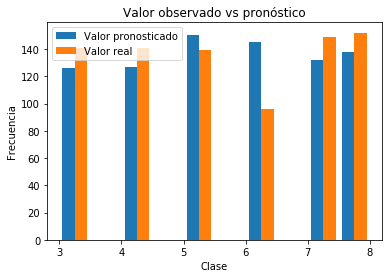

In [8]:
plt.hist([y_test,predict],label=["Valor pronosticado","Valor real"]) # Histograma de valores pronosticados
plt.title("Valor observado vs pronóstico")
plt.ylabel('Frecuencia')
plt.xlabel("Clase")
plt.legend(loc=0)
plt.show()

### Selección de características

In [9]:
rfe = RFE(logreg)
ref = rfe.fit(X_train_scaled,y_train)
car = pd.DataFrame(ref.ranking_,index=nombres[:-1],columns=["Importancia"])
print("Listado de las variables:")
print(car.sort_values(by="Importancia"))

Listado de las variables:
                      Importancia
fixed acidity                   1
volatile acidity                1
chlorides                       1
pH                              1
alcohol                         1
sulphates                       2
total sulfur dioxide            3
free sulfur dioxide             4
citric acid                     5
density                         6
residual sugar                  7


Incluyendo las variable identificadas como influyentes

In [12]:
Best = ref.ranking_ == 1  # Se seleccionan las variables consideradas como las mejores

K=[]                      # Se crea una variable para almacenar las que fueron identificadas como las mejores
for i in range(0,len(X_resampled)):
    K.append(X_resampled[i][Best])
X_new = np.asarray(K)

X_train2,X_test2 = train_test_split(X_new,test_size=0.2, random_state=1234)
scaler2 = preprocessing.StandardScaler().fit(X_train2)
X_train_scaled2 = scaler2.transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)
X_test_scaled2

# Predicción con los mejores

logreg2 = LogisticRegression()
logreg2.fit(X_train_scaled2,y_train)

predict2=logreg2.predict(X_test_scaled2)
print(confusion_matrix(y_test,predict2))
print(classification_report(y_test,predict2))

[[27 37  4  3 48  7]
 [26 44  3  4 43  7]
 [33 49  2  3 54  9]
 [41 44  6  4 42  8]
 [31 51  2  5 39  4]
 [25 52  3  6 46  6]]
              precision    recall  f1-score   support

           3       0.15      0.21      0.17       126
           4       0.16      0.35      0.22       127
           5       0.10      0.01      0.02       150
           6       0.16      0.03      0.05       145
           7       0.14      0.30      0.19       132
           8       0.15      0.04      0.07       138

    accuracy                           0.15       818
   macro avg       0.14      0.16      0.12       818
weighted avg       0.14      0.15      0.12       818



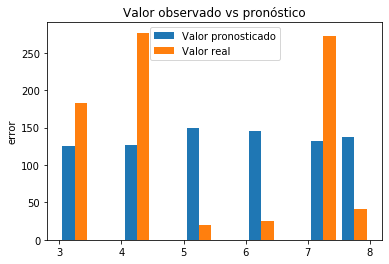

In [13]:
plt.hist([y_test,predict2],label=["Valor pronosticado","Valor real"])
plt.title("Valor observado vs pronóstico")
plt.ylabel('error')
plt.legend(loc=0)
plt.show()